In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import scienceplots
from models.HH import *
from models.LIF import * 
from models.Ishikevich import *
from models.morrislecar import *
from utils.load import *
from utils.compue_chi import *
from utils.compute_van_Rossum_distance import *
import matplotlib.animation as animation

In [5]:
plt.style.use('science')
plt.rcParams["figure.figsize"] = (12,7)

#### Setting up the experiment

We are starting with a fixed random seed, an intensity like the one in experiment 6, and a high enough time to obtain at least 100 peaks

In [6]:
#loading up the parameters

params_HH = load_HH()
params_LIF = load_LIF()
params_IZH =load_ISH()
params_ML = load_ML()

#time parameters
t_final = 7000
dt = 0.01

#fixing random seed
np.random.seed(1234)

#generating the intensity
I = np.zeros((int(t_final/dt),2))

x1 = np.random.normal(0,5,int(t_final/dt))
x2 = np.random.normal(0,5,int(t_final/dt))

I[:,0] = 2 + 5*x1
I[:,1] = 1.5 + 5*x2 


Let's see if the simulation works

In [7]:
#HH
Isyn = np.zeros(([2 , 2 ]))
tau = 0.3
V0 = -60
n0 = 0.2 
m0 = 0.1 
h0 = 0.6 
order = 5
k = 0.012
data_HH, completeHH = rk_simplemodel(dt,t_final,order,[V0,V0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I,Isyn,k,tau)


In [8]:
#LIF
Is = np.array([ [0, 0.05], [0.05, 0]])
tau = 0.65
y0 = [-60, -60]
data_IF, completeIF = rk_if(dt, t_final,order,y0,*params_LIF,I,Is,k,tau,0.7)

In [9]:
#IZH
Is = np.array([ [0, 0.05], [0.05, 0]])
tau = 0.65
y0 = [-60, -60]
u0 = [0,0]
k_izh = 0.04
data_Ish, completeIsh = rk_ish(dt,t_final,order,y0,u0,I,Is,*params_IZH,k_izh,tau)


In [10]:
#ML
k_ML = 0.008
Is = np.array([ [0, 0.05], [0.05, 0]])
tau = 0.65
y0 = [-60 , -60]
w0 = [0.0007223855976593603, 0.0007223855976593603]
data_ML, completeML = rk_ml(dt,t_final,2,y0,w0,*params_ML,I,Isyn,k_ML,tau)

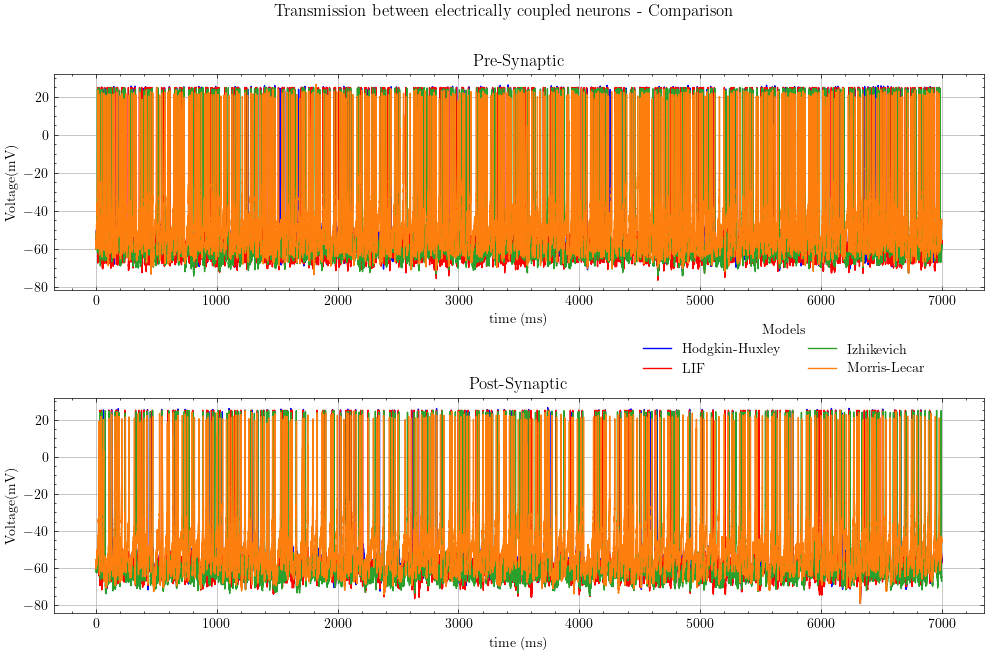

In [11]:
time = np.linspace(0,t_final,int(t_final/dt))

fig, (ax1, ax2) = plt.subplots(2,1) 

fig.subplots_adjust(hspace=0.5)
ax1.set_xlabel('time (ms)')
ax2.set_xlabel('time (ms)')

ax1.set_ylabel('Voltage(mV)')
ax2.set_ylabel('Voltage(mV)')

#ax1.set_xlim(0,100)
#ax2.set_xlim(0,100)


plt.suptitle('Transmission between electrically coupled neurons - Comparison')

ax1.title.set_text('Pre-Synaptic')
ax1.plot(time,data_HH[:,0], color = 'b', label = 'HH')
ax1.plot(time,data_IF[:,0], color = 'r', label = 'LIF')
ax1.plot(time,data_Ish[:,0], color = 'tab:green', label = 'Izhikevich')
ax1.plot(time,data_ML[:,0], color = 'tab:orange', label = 'Morris-Lecar' )

ax2.title.set_text('Post-Synaptic')

ax2.plot(time,data_HH[:,1], label = 'Hodgkin-Huxley', color = 'b')
ax2.plot(time,data_IF[:,1], label =' LIF', color= 'red')
ax2.plot(time,data_Ish[:,1], color = 'tab:green', label = 'Izhikevich')
ax2.plot(time,data_ML[:,1], color = 'tab:orange', label = 'Morris-Lecar')



ax2.legend(title = 'Models',bbox_to_anchor=(0.95, 1.4),ncols=2)
ax1.grid()
ax2.grid()

plt.show()

Feels like enough spikes

#### Synchrony measurements

##### 1.- Peaks in mean voltage
Compute average voltage.

Find peaks in average voltage

Count the number of peaks

(How to count peaks in models that are not the LIF)

##### 2.- Chi measure (function)

In [12]:
chi_HH = compute_chi(data_HH)
chi_LIF = compute_chi(data_IF)
chi_IZH = compute_chi(data_Ish)
chi_ML = compute_chi(data_ML)

In [24]:
print(' chi_HH:', chi_HH, '\n chi_LIF:' ,chi_LIF,'\n chi_IZH:', chi_IZH, '\n chi_ML:' ,chi_ML)

 chi_HH: 0.49780525181586205 
 chi_LIF: 0.49739497919430314 
 chi_IZH: 0.5472571345059186 
 chi_ML: 0.5124645290685675


##### 3.- Van Rossum distance (function)
Obtain the spike matrix 

Find average van Rossum distance

Normslise it by firing reate (also obtained through the spike matrix)